# rkev
---
- Exploring evolutionary approaches to Runge-Kutta (and discovering why symplectic approaches are better)
- Author   : [Jackson Cole](http://jacksoncole.io)
- Institute: Middle Tennessee State University
- Semester : Fall 2018


### Description
---
- This notebook contains two primary items:
- Implementation of a nbody Python package that simplifies the setup of a full *n*-body simulation.
- **(12/14/18 01:25) IN PROGRESS** An implementation of a genetic algorithm to optimize a Butcher Tableau to reduce changes in energy over the course of the simulation.
- In both of these cases, a general purpose s-stage Runge-Kutta library written in C++ is also being tested. As of (12/14/18 01:25), this appears to be working. It is wrapped up in the integration methods of the **nbody** package.

### Imports

In [1]:
import json
import math
import multiprocessing
import random
import time

from deap import algorithms, base, creator, tools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import nbody as nb

In [2]:
# Matplotlib configuration
matplotlib.use('nbagg')
%matplotlib notebook

### Setting up Butcher Tableaus
Here, I'm defining a dictionary of well known Runge-Kutta schemes. These can be used to show that the underlying methods work.

In [3]:
BT = {}
BT['RK4'] = [
    [   0.,   0.,   0.,   0.,   0.],
    [ 1/2., 1/2.,   0.,   0.,   0.],
    [ 1/2.,   0., 1/2.,   0.,   0.],
    [   1.,   0.,   0.,   1.,   0.],
    [   0., 1/6., 1/3., 1/3., 1/6.]
]

BT['RK38'] = [
    [   0.,   0.,   0.,   0.,   0.],
    [ 1/3., 1/3.,   0.,   0.,   0.],
    [ 2/3.,-1/3.,   1.,   0.,   0.],
    [   1.,   1.,  -1.,   1.,   0.],
    [   0., 1/8., 3/8., 3/8., 1/8.]
]

BT['zeros'] = [
    [ 0., 0., 0., 0., 0.],
    [ 0., 0., 0., 0., 0.],
    [ 0., 0., 0., 0., 0.],
    [ 0., 0., 0., 0., 0.],
    [ 0., 0., 0., 0., 0.]
]


### Testing the rk_ext library with some simple first order ODEs
---
The last set of tests uses a Butcher Tableau of zeros to show that there are no hidden tableaus elsewhere in the library.

In [5]:
def test_ode(t, x):
    return x/(1 + t)

def test_analytical(t):
    return t + 1

In [6]:
RK4 = nb.rk_ext.RKIntegrator(test_ode, BT['RK4'], 10, 0, 2, 1, True)
solution = RK4.run()
error = ((solution - test_analytical(2))/test_analytical(2))*100
print("solution = {}".format(solution))
print("error    = {}".format(error))

solution = 3.0000000000000004
error    = 1.4802973661668752e-14


In [7]:
RK38 = nb.rk_ext.RKIntegrator(test_ode, BT['RK38'], 10, 0, 2, 1, True)
solution = RK38.run()
error = ((solution - test_analytical(2))/test_analytical(2))*100
print("solution = {}".format(solution))
print("error    = {}".format(error))

solution = 3.0000000000000004
error    = 1.4802973661668752e-14


In [8]:
RKzero = nb.rk_ext.RKIntegrator(test_ode, BT['zeros'], 10, 0, 2, 1, True)
solution = RKzero.run()
error = ((solution - test_analytical(2))/test_analytical(2))*100
print("solution = {}".format(solution))
print("error    = {}".format(error))

solution = 1.0
error    = -66.66666666666666


## Implementation (no GA)
---
**NOTES**
- (12/14/18 00:52) The initial implementation of the nbody code was carried out step by step for readability in the Jupyter Notebook, but at this point, I am moving all of that code into a wrapper function that will be used as an evaluation function for DEAP.

### Setting up bodies

In [9]:
sun = nb.Body(mass=1.988e30,
           position=[0, 0, 0],
           velocity=[0, 0, 0],
           name='sun',
          )

earth = nb.Body(mass=5.972e24,
           position=[149597870700, 0, 0],
           velocity=[0, 29.8e3*3600, 0],
           name='earth',
          )

#mars = nb.Body(mass=0.64171e24,
#           position=[227.92e9, 0, 0],
#           velocity=[0, 24.07e3*3600*24, 0],
#           name='earth',
#          )
#
#jupiter = nb.Body(mass=1898.19e24,
#           position=[778.57e9, 0, 0],
#           velocity=[0, 13.06e3*3600*24, 0],
#           name='earth',
#          )
bodies = [sun, earth]

### The below is a time dictionary where the first key is the unit, and the second key is a common value.

In [10]:
times = {
    'second':{
        'second':1,
        'minute':60,
        'hour':3600,
        'day':24*3600,
        'year':365.25*24*3600,
    },
    'minute':{
        'second':1/60.,
        'minute':1.,
        'hour':60,
        'day':24*60,
        'year':365.25*24*60,
    },
    'hour':{
        'second':1/3600.,
        'minute':1/60.,
        'hour':1,
        'day':24,
        'year':365.25*24,
    },
    'day':{
        'second':1/(24*3600),
        'minute':1/(24*60.),
        'hour':1/24.,
        'day':1,
        'year':365.25,
    }
}

### Plotting Function

In [11]:
def plot(system, corrected, window_size, time_dict):
    t_init = time_dict['t_init']
    t_fin = time_dict['t_fin']
    steps = time_dict['steps']
    if steps == int(1e4):
        bound = list(range(steps+2))
    elif steps == int(1e5):
        bound = list(range(steps+1))
    
    AU = 149597870700
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(system.data['x'][0], system.data['y'][0], color='orange', s=100)
    for i in range(1, len(system.body_list)):
        ax1.scatter(system.data['x'][i],
                 system.data['y'][i],
                 c=bound, cmap="inferno", s=0.2)

    ax1.set_xlim([-window_size*AU,window_size*AU])
    ax1.set_ylim([-window_size*AU,window_size*AU])
    #cax = ax1.imshow()
    #cbar = fig.colorbar(cax)

    plt.title('Orbit of Bodies Around Sun, {} energy loss correction'.format(corrected))
    plt.savefig("decaying_orbits.png", dpi=300)
    plt.show()

    E = system.energy
    dE = [((e - E[0])/abs(E[0]))*100 for e in E]

    fig = plt.figure()
    #ax1 = fig.add_subplot(111)
    plt.scatter(range(len(dE)), dE, c=bound, cmap="inferno", s=0.2)
    plt.colorbar()
    plt.title('Percent Change in Energy from Initial')
    plt.ylabel('Percentage of Initial Energy')
    plt.xlabel('Iteration')
    plt.tight_layout()
    plt.show()

### run definition

In [12]:
def run(bt, bodies, time_dict):
    t_init = time_dict['t_init']
    t_fin = time_dict['t_fin']
    steps = time_dict['steps']

    system = nb.System(bodies)
    system.setup_integrators(bt, t_init, t_fin, steps)

    start = time.process_time()

    system.run()

    end = time.process_time()
    elapsed = end - start

    print("time elapsed = " + str(elapsed))
    print("----------------------------------------------------")
    print("TOTAL ENERGY CHANGE")
    print("----------------------------------------------------")
    print("absolute   = {:15.5e}".format(system.energy_change['absolute']))
    print("percentage = {:15.5e}".format(system.energy_change['percentage']))
    
    return system

In [13]:
times['second']['year']

31557600.0

time elapsed = 1.404484
----------------------------------------------------
TOTAL ENERGY CHANGE
----------------------------------------------------
absolute   =     5.27282e+49
percentage =     1.53821e+11


<IPython.core.display.Javascript object>


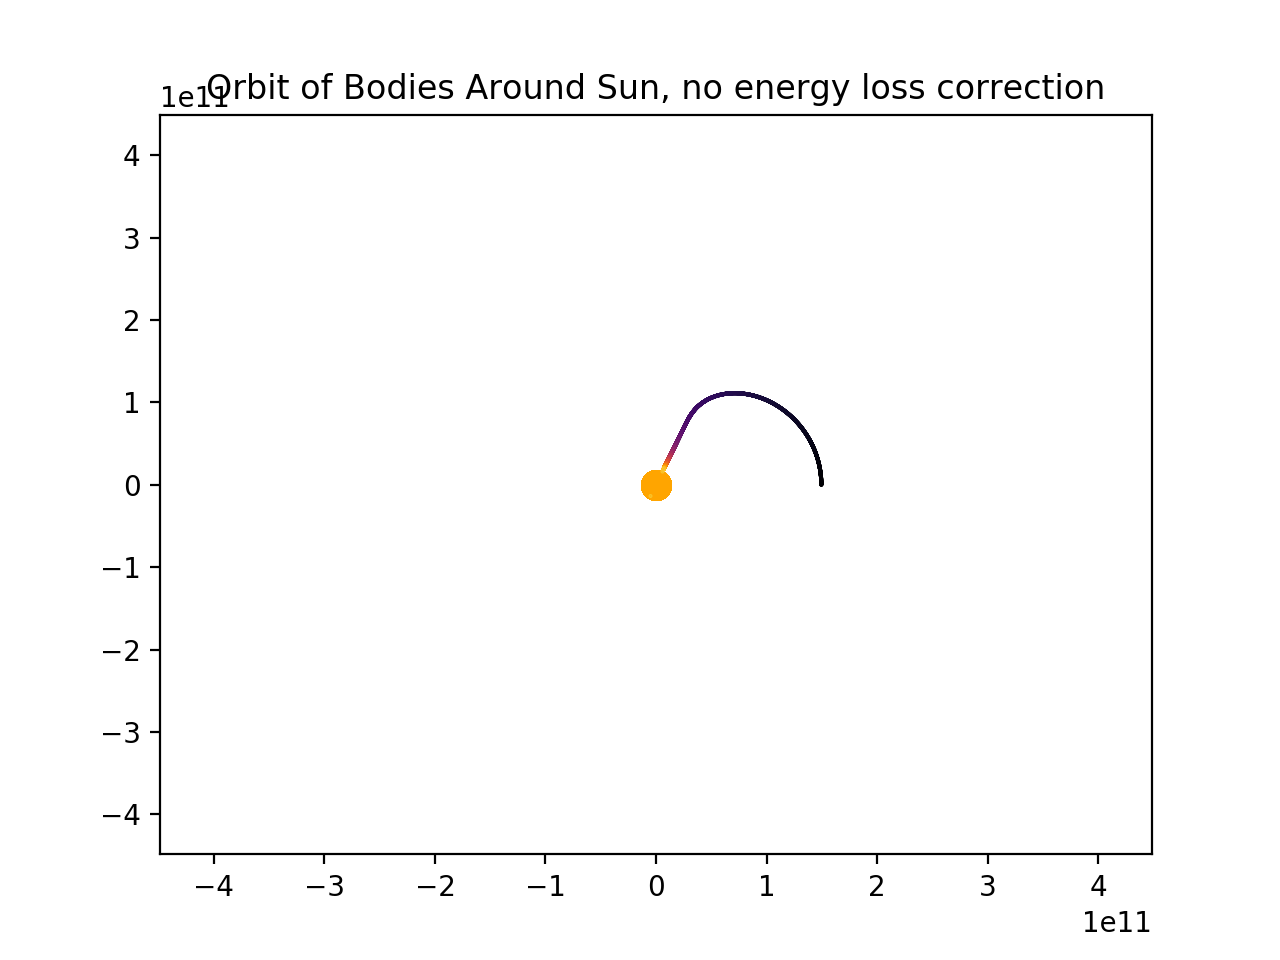

<IPython.core.display.Javascript object>


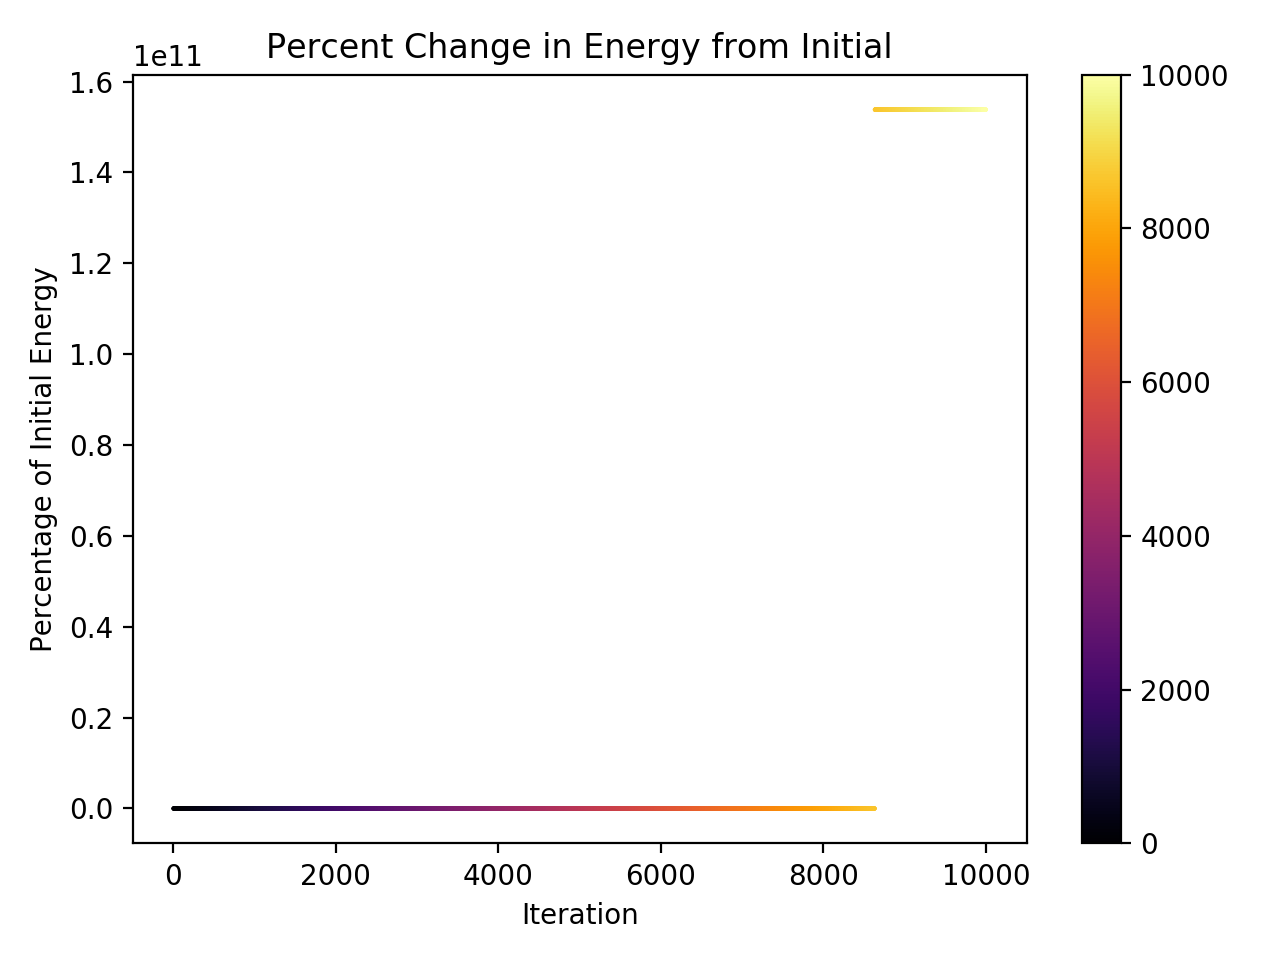

In [15]:
time_dict = {
    't_init':0.,
    't_fin':1.5*times['hour']['year'],
    'steps':int(1e4),
}

window_size = 3
system = run(BT['RK4'], bodies, time_dict)
plot(system, 'no', window_size, time_dict)

In [ ]:
#print(system.data['vx'][0][:5])
#print(system.data['vy'][0][:5])
#print(system.data['vz'][0][:5])
#print(system.data ['x'][0][:5])
#print(system.data ['y'][0][:5])
#print(system.data ['z'][0][:5])
#print(system.data['ac'][0][-5:])

# Moving on to GA using DEAP
---
The standard Runge-Kutta method is undoubtedly *not* the best method for these types of problems, and we could easily arrive at a solution that conserves energy by using a symplectic integrator... but that's not what we're going to do.

In this case, we're going to attempt to use DEAP to evolve the Butcher Tableau to minimize the overall change in energy. Basically, we've got a giant, multipurpose hammer (non-symplectic Runge-Kutta), so we just need to make our problem look like a nail.

In [32]:
def evaluate(individual, time_dict):
    """This is the function that will be used to evaluate
    the individuals. To be used for other systems, all of
    the definitions need to either be made here or the
    argument list must be augmented to contend with extra
    parameters.
    """
    t_init = time_dict['t_init']
    t_fin = time_dict['t_fin']
    steps = time_dict['steps']
     
    # Initialize the system (notice the usage of "individual")
    system = nb.System(bodies)
    #print("HERE IT IS: {}".format(type(individual)))
    system.setup_integrators(individual, t_init, t_fin, steps)
   
    # Run
    start = time.process_time()

    system.run()

    end = time.process_time()
    elapsed = end - start

    #print("time: {}".format(elapsed))
    
    return (system.energy_change['percentage'],)

# TEST: Make sure the above function actually works
energy_change = evaluate(BT["RK4"], time_dict)
print("energy change = {}".format(energy_change))

energy change = (-1018.5356785671061,)


In [21]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [33]:
bts = list(BT.values())
def init_tableau(icls):
    bt = bts[random.randint(0, 1)]
    bt = np.asarray(bt)*random.random()
    bt = bt.tolist()
    return icls(bt)

In [ ]:
toolbox = base.Toolbox()
toolbox.register("init_individual", init_tableau)
toolbox.register("individual", toolbox.init_individual, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate, time_dict=time_dict)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.3, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


In [ ]:
population = toolbox.population(n=20)
NGEN=15
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
top10 = tools.selBest(population, k=10)

In [19]:
print('Best Remaining Individual after {} generations:'.format(NGEN))
a = [[0.0, 0.0, 0.0, 0.0, 0.0],
 [0.3636733144010224, 0.3636733144010224, 0.0, 0.0, 0.0],
 [0.3636733144010224, 0.0, 0.3636733144010224, 0.0, 0.0],
 [0.7677566283239672,
  0.7677566283239672,
  -0.7677566283239672,
  0.7677566283239672,
  0.0],
 [0.0,
  0.0959695785404959,
  0.28790873562148767,
  0.28790873562148767,
  0.0959695785404959]]
print('[')
for row in a:
    print('    ' + str(row) + ',')
print(']')
#print(ind.fitness.values)

Best Remaining Individual after 15 generations:
[
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.3636733144010224, 0.3636733144010224, 0.0, 0.0, 0.0],
    [0.3636733144010224, 0.0, 0.3636733144010224, 0.0, 0.0],
    [0.7677566283239672, 0.7677566283239672, -0.7677566283239672, 0.7677566283239672, 0.0],
    [0.0, 0.0959695785404959, 0.28790873562148767, 0.28790873562148767, 0.0959695785404959],
]


time elapsed = 1.3868929999999988
----------------------------------------------------
TOTAL ENERGY CHANGE
----------------------------------------------------
absolute   =    -2.80393e+41
percentage =    -8.17977e+02


<IPython.core.display.Javascript object>


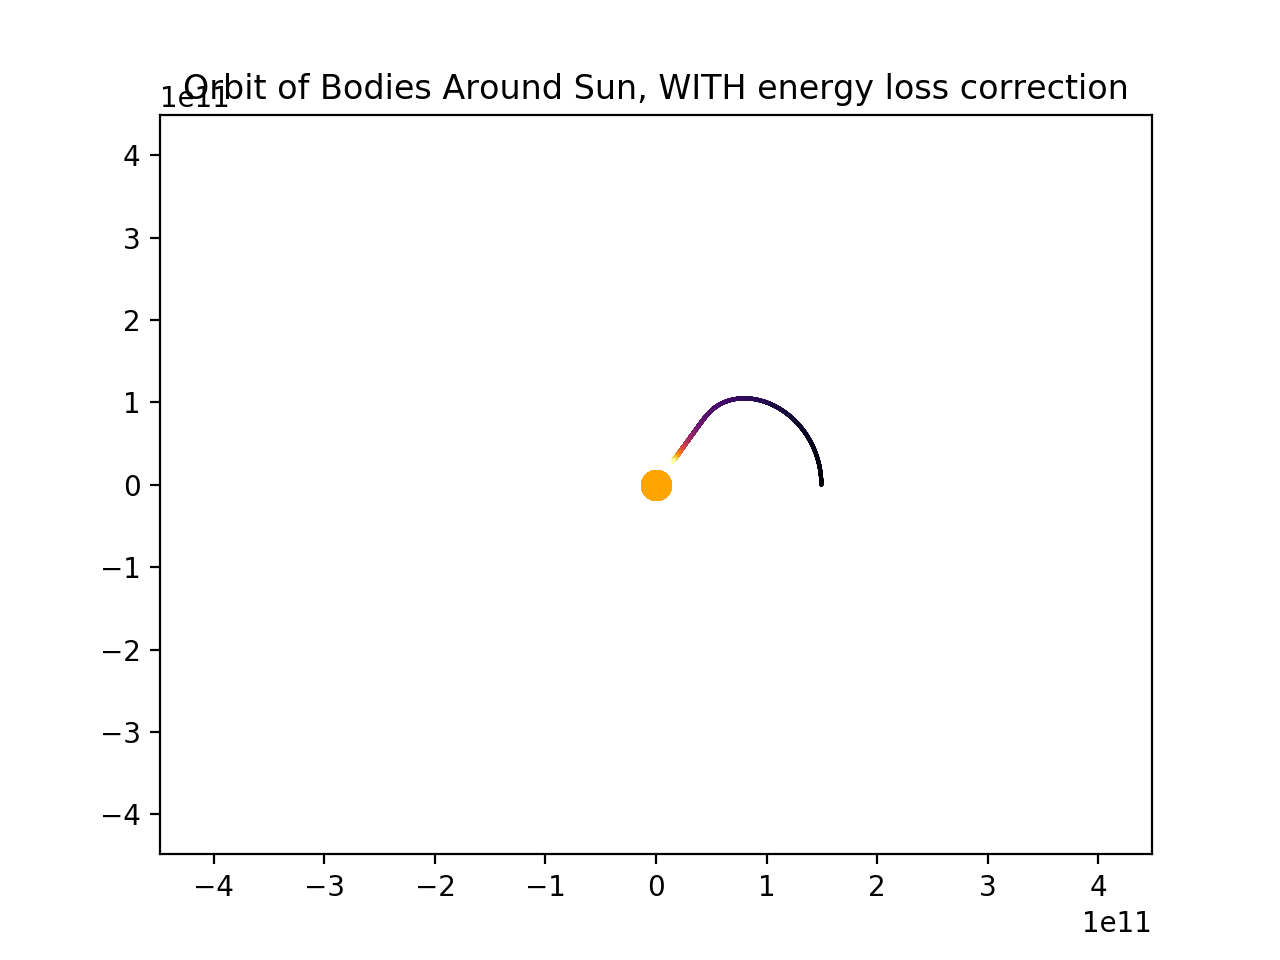

<IPython.core.display.Javascript object>


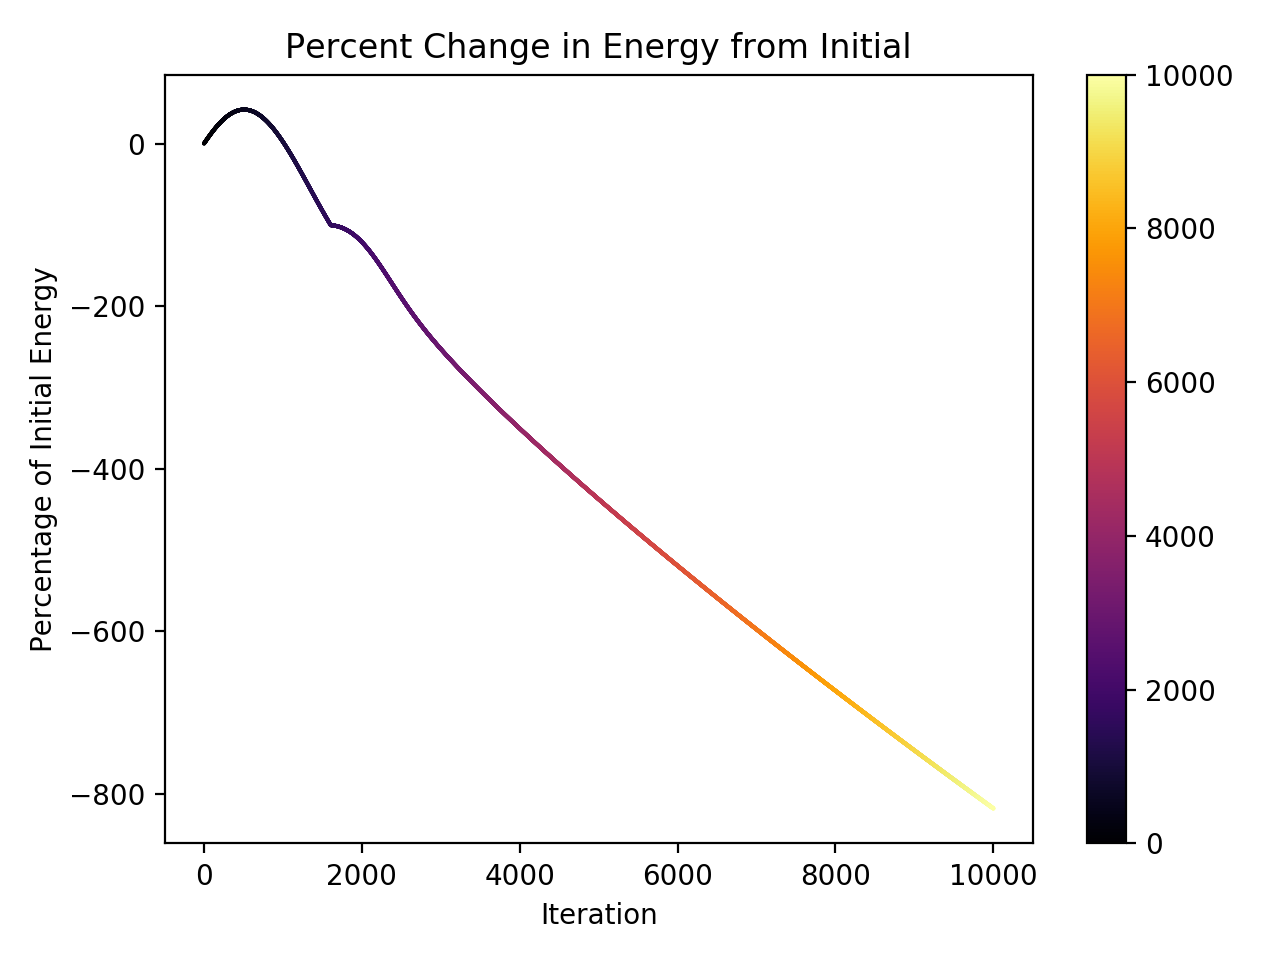

In [16]:
time_dict = {
    't_init':0.,
    't_fin':1.5*times['hour']['year'],
    'steps':int(1e4),
}

window_size = 3
system = run(a, bodies, time_dict)
plot(system, 'WITH', window_size, time_dict)

### Resources
---
-  https://thesesergio.wordpress.com/2013/05/31/deap-a-self-made-tutorial-12/comment-page-1/#comment-98